# **Project Introduction**

## Dataset description

Estimation of HDB Resale Flats Pricing in Singapore using Machine Learning
The dataset is focused on the HDB resale transaction prices in Singapore. Housing Development Board (HDB) has published housing data containing 10 distinct types of metrics such as month registered for resale, town, flat types, etc. The data is published by the Singapore government and hence holds a high degree of reliability and accuracy.

## Motivation/Problem Statement


This project is crucial in addressing the rising demand for housing in the face of a growing population and escalating costs in land-scarce Singapore. With concerns about affordability on the rise, the project focuses on helping individuals estimate resale flat prices, enabling them to strategically plan and explore housing options that fit their financial constraints and specific criteria. We will be focusing on leveraging machine learning techniques to predict resale flat prices.


## Key Questions:

1. What are the primary factors affecting the price of resale flats in Singapore?
2. Which features should we use for our predictive model?
3. What are some limitations/biases that might occur in the predictive model?
4. Will the model be able to capture temporal trends in the market?
5. How will the model be affected by outliers that indicate high levels of risk?


By addressing these key questions, this project aims to provide a valuable tool for individuals in Singapore to better plan and navigate the complex housing market, ultimately helping them make more informed decisions when buying or selling resale flats.

# **Getting Started**

Clone the git repository into your local directory





git clone https://github.com/Cheenaswee/CS3244-Machines-That-Learn.git

# **Data Extraction, Collection & Preparation**

## Unzipping the Datasets.zip file

Running the code will extract the resale_data.csv into the Dataset folder


In [18]:
import os
import zipfile

zip_directory = r"../CS3244-Machines-That-Learn/Dataset"
zip_file_path = os.path.join(zip_directory, "resale_flat.zip")
extract_to_directory = r"../CS3244-Machines-That-Learn/Dataset"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print("Error: Zip file does not exist")
    exit()

# Check if the extraction directory exists
if not os.path.exists(extract_to_directory):
    os.makedirs(extract_to_directory)
    print(f"Created extraction directory: {extract_to_directory}")

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)
    print("Extraction completed successfully.")

Extraction completed successfully.


# **Import Basic Libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import requests
import re

## Reading in Resale Flat Prices Data

Link to Data: https://www.kaggle.com/datasets/mikelll/singapore-housing-price-20172022

In [2]:
dataset = pd.read_csv(r"..\CS3244-Machines-That-Learn\Dataset\resale_flat.csv")

In [3]:
print(dataset)

          month        town  flat_type block        street_name storey_range  \
0       2017-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1       2017-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2       2017-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3       2017-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4       2017-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...         ...         ...        ...   ...                ...          ...   
134163  2022-08      YISHUN     5 ROOM   850       YISHUN ST 81     01 TO 03   
134164  2022-08      YISHUN  EXECUTIVE   325        YISHUN CTRL     07 TO 09   
134165  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134166  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134167  2022-08      YISHUN  EXECUTIVE   643       YISHUN ST 61     10 TO 12   

        floor_area_sqm      flat_model 

## Feature Selection
We do feature selection to determine the top 5 features that are most relevant in our dataset. We aim to improve model performance and prevent the "curse of dimensionality"

For our feature selection, we use the method of Random Forest and Recursive Feature Elimnation. First, we will find the best number of estimators to use for the Random Forest Model. 

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Load a subset of the dataset2
dataset2 = pd.read_csv(r"..\CS3244-Machines-That-Learn\Dataset\resale_flat.csv").head(10)

# Separate features and target variable
X = dataset2.drop(['resale_price', 'month'], axis=1)  # Drop 'month' column
y = dataset2['resale_price']

# Encode categorical features
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]  # Example values for n_estimators
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best RMSE:", np.sqrt(best_score))

Best Parameters: {'n_estimators': 250}
Best RMSE: 17932.72887209306


## Finding the best features with Random Forest and Recursive Feature Elimnation 

We got the following 5 features from feature selection
1. floor_area_sqm
2. lease_commerce_date
3. flat_model
4. remaining_lease
5. flat_type

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split  # Add this import statement


# Separate features and target variable
X = dataset2.drop(['resale_price', 'month'], axis=1)  # Drop 'month' column since it is not relevant as the timeframe is too short
y = dataset2['resale_price']

# Encode categorical features
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf, n_features_to_select=5, step=1)

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]

# Print selected features
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['floor_area_sqm', 'lease_commence_date', 'flat_model_Improved',
       'flat_model_New Generation', 'remaining_lease_62 years 05 months'],
      dtype='object')


## Convert non-numerical data into numerical

In [6]:
le_flat_type = LabelEncoder()
dataset['flat_type'] = le_flat_type.fit_transform(dataset['flat_type'])
le_flat_model = LabelEncoder()
dataset['flat_model'] = le_flat_model.fit_transform(dataset['flat_model'])

# Function to convert remaining lease to months
def convert_remaining_lease_to_months(remaining_lease_str):
    parts = remaining_lease_str.split()
    total_months = 0
    
    for i in range(0, len(parts), 2):
        if parts[i+1] == 'years':
            total_months += int(parts[i]) * 12
        elif parts[i+1] == 'months':
            total_months += int(parts[i])
    
    return total_months

# Convert 'remaining_lease' to numerical format in months
dataset['remaining_lease_months'] = dataset['remaining_lease'].apply(convert_remaining_lease_to_months)

## Split the dataset into training and testing sets

## RMB TO COME BACK EDIT THIS, ADD 2 MORE X INPUTS, I REMOVE NOW COS TAKE DAM LONG TO LOAD. ADD IN remaining_lease_months and lease_commence_date

In [7]:
X = dataset[['flat_type', 'flat_model', 'floor_area_sqm']]  
y = dataset['resale_price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Further split the training set into training and validation sets

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_val)

        flat_type  flat_model  floor_area_sqm
80390           2          12            68.0
24836           4          17           117.0
30639           3           8           114.0
133513          3          10            90.0
65349           3           8            92.0
...           ...         ...             ...
15948           3          12            91.0
43833           3           8           103.0
73114           2          12            82.0
15691           2          12            67.0
14198           3          13            93.0

[10734 rows x 3 columns]


## Scatter plot between 'floor_area_sqm' and 'resale_price'

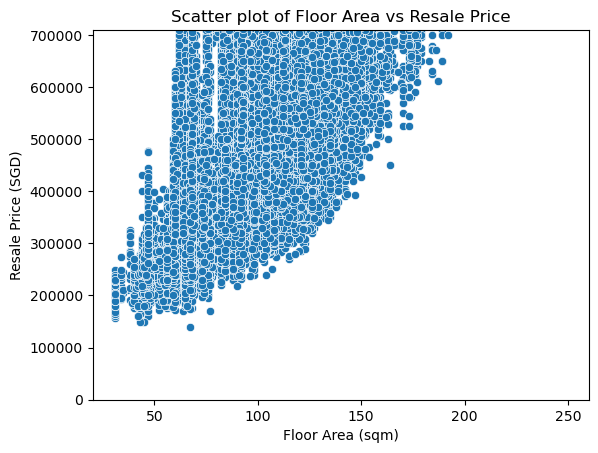

In [9]:
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=dataset)
plt.title('Scatter plot of Floor Area vs Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.5)  # Adjust multiplier as needed
plt.show()

## Scatter plot between 'lease_commence_date' and 'resale_price'

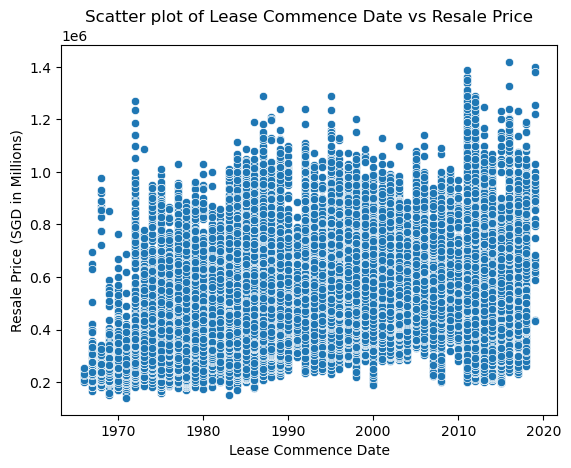

In [10]:
sns.scatterplot(x='lease_commence_date', y='resale_price', data=dataset)
plt.title('Scatter plot of Lease Commence Date vs Resale Price')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD in Millions)')
plt.show()

## Scatter plot between 'flat_type' and 'resale_price'

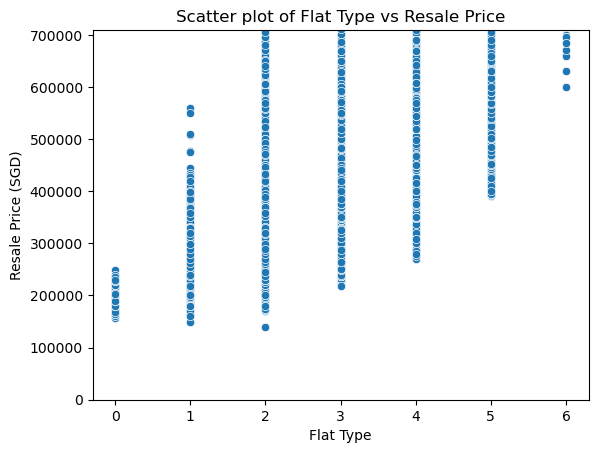

In [11]:
sns.scatterplot(x='flat_type', y='resale_price', data=dataset)
plt.title('Scatter plot of Flat Type vs Resale Price')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.5)  # Adjust multiplier as needed

plt.show()

## Scatter plot between 'remaining_lease' and 'resale_price'

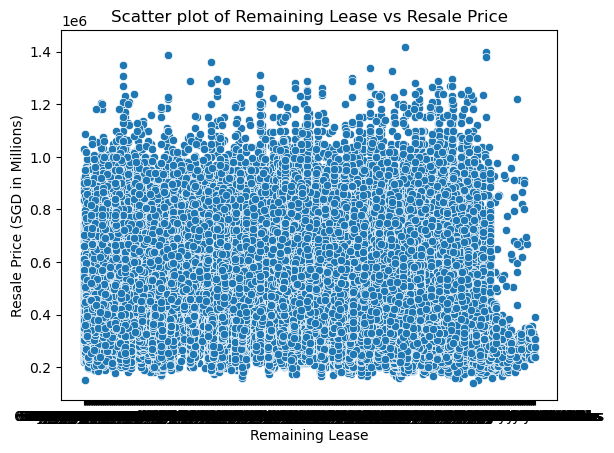

In [12]:
sns.scatterplot(x='remaining_lease', y='resale_price', data=dataset)
plt.title('Scatter plot of Remaining Lease vs Resale Price')
plt.xlabel('Remaining Lease')
plt.ylabel('Resale Price (SGD in Millions)')
plt.show()

## Scatter plot between 'flat_model' and 'resale_price'

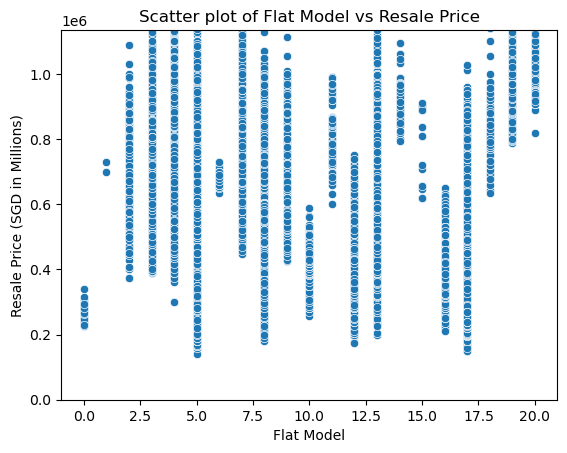

In [13]:
sns.scatterplot(x='flat_model', y='resale_price', data=dataset)
plt.title('Scatter plot of Flat Model vs Resale Price')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price (SGD in Millions)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.8)  # Adjust multiplier as needed

plt.show()

## Insights gained from plots

After analyzing the five plots provided, it's evident that a clear linear relationship exists between floor area (sqm) and resale price, as well as between flat type and resale price, and flat model and resale price. However, the remaining two plots depicting remaining_lease and lease_commence_date do not seem to exhibit any discernible relationship with resale price.

## Correlation matrix

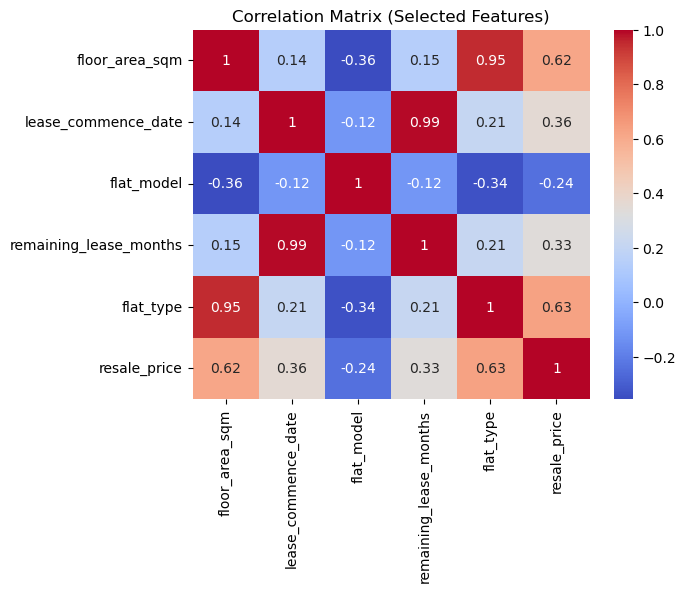

In [14]:
selected_columns = ['floor_area_sqm', 'lease_commence_date', 'flat_model', 'remaining_lease_months', 'flat_type', 'resale_price']
selected_dataset = dataset[selected_columns]

# Calculate correlation matrix
corr_matrix_selected = selected_dataset.corr(numeric_only=True)

# Plotting the correlation matrix
sns.heatmap(corr_matrix_selected, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Selected Features)')
plt.show()


## Correlation results

Based on the correlation matrix, we observe a strong correlation between flat_type and floor_area_sqm. This correlation is not coincidental; rather, it reflects the logical relationship between the two variables. A higher flat_type value signifies more rooms, which in turn implies a larger floor area (sqm). 

Moreover, we also notice a significant correlation between remaining_lease and lease_commence_date. This finding is expected as the remaining lease duration directly depends on the lease commencement date. Therefore, a higher remaining_lease typically corresponds to a later lease commencement date. As such, we have decided to remove lease_commence_date.

# **Exploring Different Models with Data**


## Linear Regression

In [15]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate Linear Regression model
y_pred_linear = linear_model.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
r2_linear = r2_score(y_val, y_pred_linear)

print("Linear Regression Results:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores:", cv_scores)
print("R^2 Score After Cross-Validation:", np.mean(cv_scores))

Linear Regression Results:
Mean Squared Error: 15609851123.954845
R^2 Score: 0.4064110871426325
Cross-Validation R^2 Scores: [0.40366388 0.40246107 0.39561245 0.39738503 0.4048981 ]
R^2 Score After Cross-Validation: 0.4008041035872488


## Random Forest

In [16]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = random_forest_model.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Results:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores_rf = cross_val_score(random_forest_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores for Random Forest:", cv_scores_rf)
print("R^2 Score After Cross-Validation:", np.mean(cv_scores_rf))

Random Forest Results:
Mean Squared Error: 10197982196.954168
R^2 Score: 0.6122058360736533
Cross-Validation R^2 Scores for Random Forest: [0.61888275 0.61714655 0.61176427 0.61888415 0.62253394]
R^2 Score After Cross-Validation: 0.6178423300191515


## Decision Trees

In [17]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_dt = decision_tree_model.predict(X_val)
mse_dt = mean_squared_error(y_val, y_pred_dt)
r2_dt = r2_score(y_val, y_pred_dt)

print("\nDecision Tree Results:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R^2 Score: {r2_dt}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores_dt = cross_val_score(decision_tree_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores for Decision Tree:", cv_scores_dt)
print("R^2 After Cross-Validation:", np.mean(cv_scores_dt))


Decision Tree Results:
Mean Squared Error: 10209063638.32431
R^2 Score: 0.6117844469980265
Cross-Validation R^2 Scores for Decision Tree: [0.61866884 0.61640565 0.6115826  0.61875107 0.62274556]
R^2 After Cross-Validation: 0.617630743133269


## SVM

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the SVM regressor
svm_regressor = SVR(kernel='rbf', C=10) #higher the C, the less tolerant it is for misclassification.

# Train the SVM regressor
svm_regressor.fit(X_train, y_train)

# Predict the target values for validation set
y_pred_svm = svm_regressor.predict(X_val)

# Evaluate SVM regressor
mse_svm = mean_squared_error(y_val, y_pred_svm)
r2_svm = r2_score(y_val, y_pred_svm)

print("\nSupport Vector Machine Results:")
print(f"Mean Squared Error: {mse_svm}")
print(f"R^2 Score: {r2_svm}")



Support Vector Machine Results:
Mean Squared Error: 20677594048.34707
R^2 Score: 0.21370226569113981


## Gradient Boosting Models

In [19]:
ada_regressor = AdaBoostRegressor(random_state=42, n_estimators=50)
ada_regressor.fit(X_train, y_train)

y_pred = ada_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nADA Boost Results:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


ADA Boost Results:
Mean Squared Error: 20566648023.08432
R^2 Score: 0.23190067732165276
